A hospital wants to reduce patient readmissions within 30 days after discharge.
Readmissions increase hospital costs and indicate poor post-treatment care. You are hired as a data analyst to build a machine learning classification model that predicts whether a patient is High Risk or Low Risk for readmission.

# Libraries

In [ ]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Load Data

In [ ]:
# Upload CSV manually in Colab, then load
df = pd.read_csv("hospital_readmissions.csv")

# Preview data
df.head()

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted
0,[70-80),8,72,1,18,2,0,0,Missing,Circulatory,Respiratory,Other,no,no,no,yes,no
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,Other,no,no,no,yes,no
2,[50-60),5,45,0,18,0,0,0,Missing,Circulatory,Circulatory,Circulatory,no,no,yes,yes,yes
3,[70-80),2,36,0,12,1,0,0,Missing,Circulatory,Other,Diabetes,no,no,yes,yes,yes
4,[60-70),1,42,0,7,0,0,0,InternalMedicine,Other,Circulatory,Respiratory,no,no,no,yes,no


In [ ]:
df.info() # Basic Overview

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                25000 non-null  object
 1   time_in_hospital   25000 non-null  int64 
 2   n_lab_procedures   25000 non-null  int64 
 3   n_procedures       25000 non-null  int64 
 4   n_medications      25000 non-null  int64 
 5   n_outpatient       25000 non-null  int64 
 6   n_inpatient        25000 non-null  int64 
 7   n_emergency        25000 non-null  int64 
 8   medical_specialty  25000 non-null  object
 9   diag_1             25000 non-null  object
 10  diag_2             25000 non-null  object
 11  diag_3             25000 non-null  object
 12  glucose_test       25000 non-null  object
 13  A1Ctest            25000 non-null  object
 14  change             25000 non-null  object
 15  diabetes_med       25000 non-null  object
 16  readmitted         25000 non-null  objec

In [ ]:
df.describe() # BAsic Statistics

,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency
count,25000.00000,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,4.45332,43.24076,1.352360,16.252400,0.366400,0.615960,0.186600
std,3.00147,19.81862,1.715179,8.060532,1.195478,1.177951,0.885873
min,1.00000,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2.00000,31.00000,0.000000,11.000000,0.000000,0.000000,0.000000
50%,4.00000,44.00000,1.000000,15.000000,0.000000,0.000000,0.000000
75%,6.00000,57.00000,2.000000,20.000000,0.000000,1.000000,0.000000
max,14.00000,113.00000,6.000000,79.000000,33.000000,15.000000,64.000000


### Why this is a Classification Problem
We predict whether a patient will be readmitted within 30 days.
Output is categorical:
- High Risk (1)
- Low Risk (0)

### Meaning of Classes
- **High Risk**: Patient likely to be readmitted → needs extra care
- **Low Risk**: Patient unlikely to be readmitted

# Feature Selection

| Feature             | Reason                          |
| ------------------- | ------------------------------- |
| age                 | Older patients → higher risk    |
| length_of_stay      | Longer stay → complex condition |
| previous_admissions | Strong readmission signal       |
| diagnosis           | Disease severity                |
| num_lab_tests       | Health complexity               |
| discharge_type      | Planned vs emergency            |

In [ ]:
selected_features = [
    "age",
    "time_in_hospital", # Corrected from length_of_stay
    "n_inpatient",      # Corrected from previous_admissions
    "diag_1",           # Corrected from diagnosis
    "n_lab_procedures"  # Corrected from num_lab_tests
    # "discharge_type"  # Removed as no direct match found
]

target = "readmitted"

df = df[selected_features + [target]]
df.head()

,age,time_in_hospital,n_inpatient,diag_1,n_lab_procedures,readmitted
0,[70-80),8,0,Circulatory,72,no
1,[70-80),3,0,Other,34,no
2,[50-60),5,0,Circulatory,45,yes
3,[70-80),2,0,Circulatory,36,yes
4,[60-70),1,0,Other,42,no


# Encode Categorical Variables

In [ ]:
label_encoders = {}

for col in df.select_dtypes(include="object").columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Split Data

In [ ]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
X_train

,age,time_in_hospital,n_inpatient,diag_1,n_lab_procedures
7846,2,2,0,6,31
24980,4,5,0,3,84
305,4,3,0,1,53
9549,3,7,0,6,45
1607,4,1,1,2,14
...,...,...,...,...,...
5082,3,3,0,5,48
9888,2,4,0,6,36
1178,1,3,0,6,44
21813,2,3,1,5,59


# Decision Tree

In [ ]:
dt = DecisionTreeClassifier(
    max_depth=4,
    min_samples_split=20,
    random_state=42
)

dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_split=20, random_state=42)

# Decision Tree Evaluation

In [ ]:
dt_preds = dt.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, dt_preds))
print(classification_report(y_test, dt_preds))

Decision Tree Accuracy: 0.61424
              precision    recall  f1-score   support

           0       0.61      0.78      0.68      3312
           1       0.63      0.43      0.51      2938

    accuracy                           0.61      6250
   macro avg       0.62      0.60      0.60      6250
weighted avg       0.62      0.61      0.60      6250



# Decision Tree feature importance

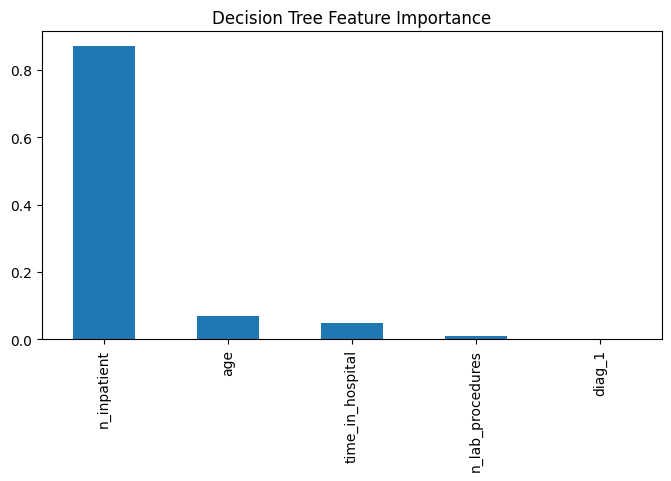

In [ ]:
importance = pd.Series(dt.feature_importances_, index=X.columns)
importance.sort_values(ascending=False).plot(kind="bar", figsize=(8,4))
plt.title("Decision Tree Feature Importance")
plt.show()

# Visualize deecision Tree

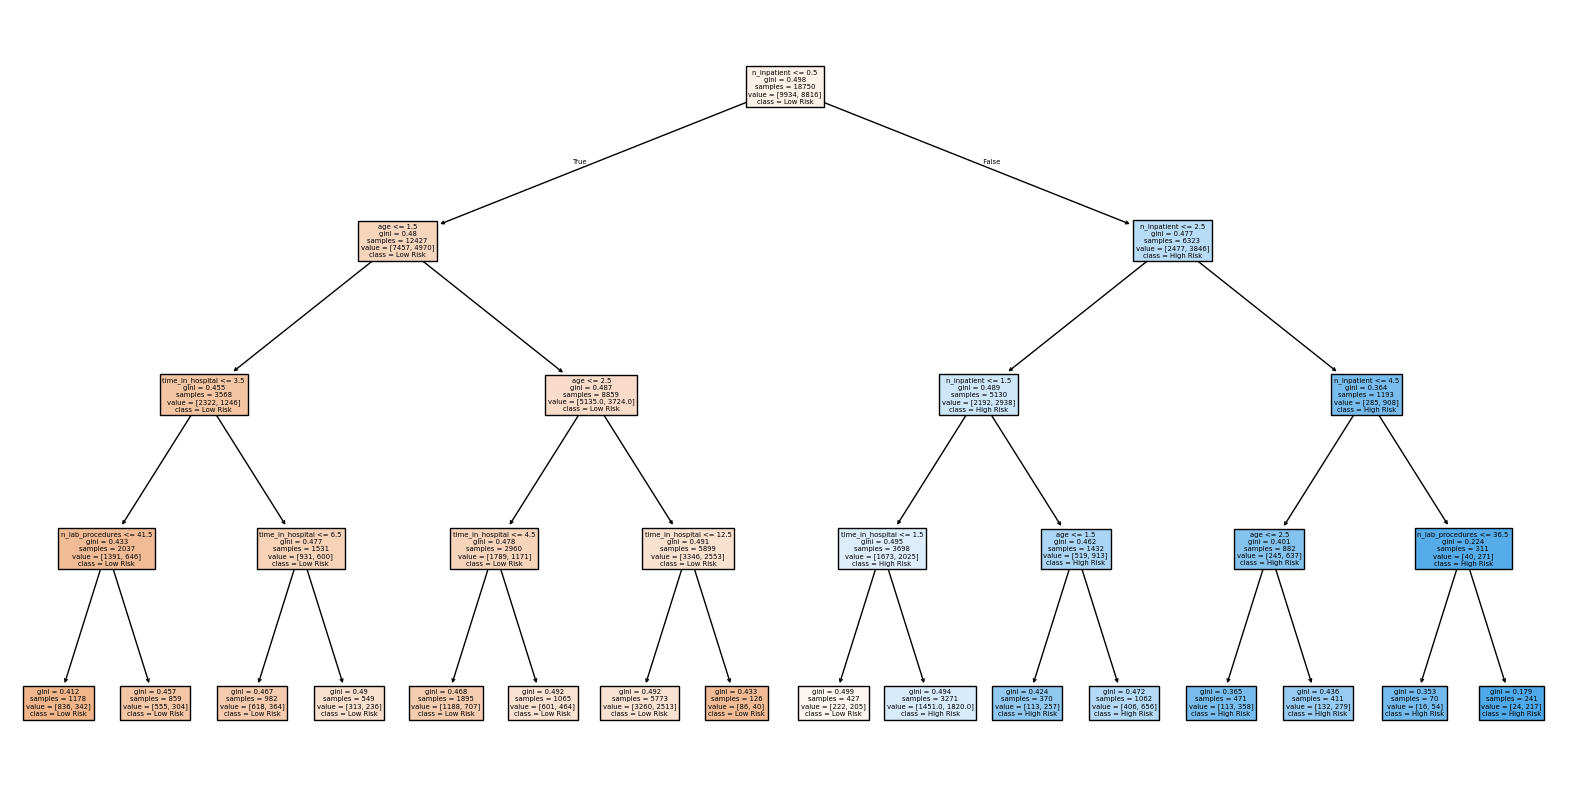

In [ ]:
plt.figure(figsize=(20,10))
plot_tree(
    dt,
    feature_names=X.columns,
    class_names=["Low Risk", "High Risk"],
    filled=True
)
plt.show()

# Scale Data for SVM

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM (RBF kernal)

In [ ]:
svm = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",
    probability=True,
    random_state=42
)

svm.fit(X_train_scaled, y_train)

SVC(probability=True, random_state=42)

# SVM Evaluation

In [ ]:
svm_preds = svm.predict(X_test_scaled)

print("SVM Accuracy:", accuracy_score(y_test, svm_preds))
print(classification_report(y_test, svm_preds))

SVM Accuracy: 0.60976
              precision    recall  f1-score   support

           0       0.60      0.77      0.68      3312
           1       0.62      0.43      0.51      2938

    accuracy                           0.61      6250
   macro avg       0.61      0.60      0.59      6250
weighted avg       0.61      0.61      0.60      6250



# SVM Internal Decision Explanation (Probaility

In [ ]:
svm_probs = svm.predict_proba(X_test_scaled)[:10]

pd.DataFrame(
    svm_probs,
    columns=["Low Risk Probability", "High Risk Probability"]
)

,Low Risk Probability,High Risk Probability
0,0.344270,0.655730
1,0.602686,0.397314
2,0.602619,0.397381
3,0.602781,0.397219
4,0.598074,0.401926
5,0.602615,0.397385
6,0.383313,0.616687
7,0.602768,0.397232
8,0.602800,0.397200
9,0.359112,0.640888


# Confusion Matrix Comparision

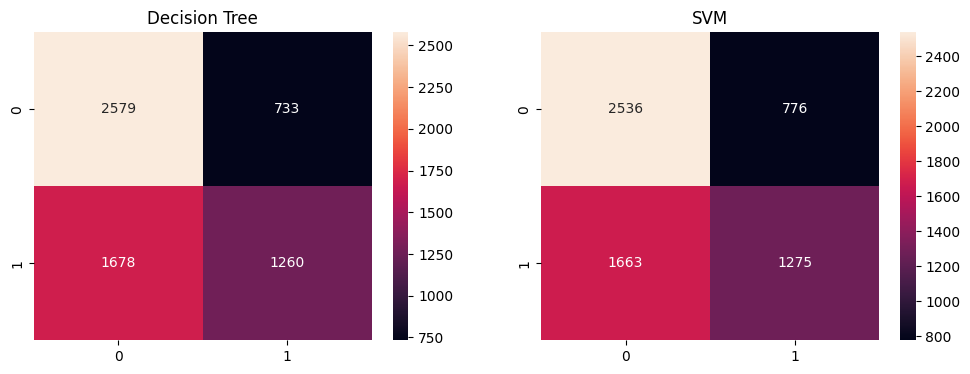

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

sns.heatmap(confusion_matrix(y_test, dt_preds), annot=True, fmt="d", ax=ax[0])
ax[0].set_title("Decision Tree")

sns.heatmap(confusion_matrix(y_test, svm_preds), annot=True, fmt="d", ax=ax[1])
ax[1].set_title("SVM")

plt.show()

# Final Summary

### Final Results
- Decision Tree: Interpretable, rule-based decisions
- SVM (RBF): Higher complexity, better at non-linear patterns

### Business Impact
- High-risk patients can receive early follow-up
- Reduces hospital readmission costs
- Improves patient care quality
